# Aprendizaje del manejo de la libreria de esios

## Objetivo

https://api.esios.ree.es
  
Manuel H. Arias  
[@walyt](https://twitter.com/walyt)  

[#escovid19data](https://github.com/montera34/escovid19data)

versión definitiva documentada, para ser publicar en el repo

[@walyt](https://twitter.com/walyt)

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [14]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
import json
import string
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange,date2num,num2date)
import matplotlib.patches as mpatches
import matplotlib.units as munits

import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime,timedelta,date
import seaborn as sns
%matplotlib inline

from adjustText import adjust_text

import fitz
import html
import twitter
import sys
import locale

sys.path.append("/Users/mharias/Documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares
sys.path.append("/Users/mharias/Documents/proyectos/consumo_luz/code")

from pass_esios import token_esios,apikey_walyt,apisecretkey_walyt,AccessToken_walyt,AccessTokenSecret_walyt

from herramientas import download_esios, download_ree,renombra_columnas, download_gas

In [15]:
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')

'es_ES.UTF-8'

In [16]:
#formateamos pantalla
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:,.2f}'.format

In [17]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [18]:
headers = {'Accept':'application/json; application/vnd.esios-api-v2+json',
           'Content-Type':'application/json',
           'Host':'api.esios.ree.es',
           'Cookie' : '',
           'Authorization':'Token token={}'.format(token_esios),
           'Cache-Control': 'no-cache',
           'Pragma': 'no-cache'
          }
url = 'https://api.esios.ree.es/indicators'



# Solo spot diario en el día

https://www.esios.ree.es/es/analisis/10211?vis=1&start_date=18-12-2022T00%3A00&end_date=18-12-2022T23%3A00&compare_start_date=17-12-2022T00%3A00&groupby=hour&compare_indicators=805,806,807,808,809,810,811,812,813,814,815,816,1277,10403,1286,1368

https://www.esios.ree.es/es/analisis/600?vis=1&start_date=18-12-2022T00%3A00&end_date=18-12-2022T23%3A00&compare_start_date=17-12-2022T00%3A00&groupby=hour&geoids=3


In [19]:
inicio = (date.today()-timedelta(days=365))
ayer = (date.today()-timedelta(days=1))


In [20]:
indicadores = [805,806,807,808,809,810,811,812,813,814,815,816,1277,10403,1286,1368]

In [21]:
raw_spot_historico = download_esios(token_esios,indicadores,inicio.strftime('%Y-%m-%d'),ayer.strftime('%Y-%m-%d'),time_trunc='day')

In [22]:
historico = (raw_spot_historico
 .assign(tipo = lambda df_: df_['short_name'].map(lambda x: 'Spot' if x=='Mercado Diario' else 'Ajuste Gas' if x=='Mecanismo de ajuste RD-L 10/2022' else 'Otros'))
 .assign(hora=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(precio = lambda df_: df_['value']/24)
 .loc[:,['hora','tipo','precio']]
 .groupby(['hora','tipo'])
 .sum()
 .reset_index()
)

In [23]:
historico.groupby(['hora']).sum().reset_index()

,hora,precio
0,2021-12-27,110.06
1,2021-12-28,115.98
2,2021-12-29,188.57
3,2021-12-30,208.05
4,2021-12-31,152.87
...,...,...
360,2022-12-22,73.69
361,2022-12-23,52.12
362,2022-12-24,58.81
363,2022-12-25,47.82


In [24]:
historico.groupby(['hora']).sum().reset_index()['precio'].mean()

202.93184132420083

In [25]:
anno_media = historico.groupby(['hora']).sum().reset_index()['precio'].mean()

In [26]:
ayer_media =  historico.groupby(['hora']).sum().reset_index().iloc[-1]['precio']

In [27]:
mes_media = historico.groupby(['hora']).sum().reset_index().iloc[-31:]['precio'].mean()

In [28]:
semana_media = historico.groupby(['hora']).sum().reset_index().iloc[-7:]['precio'].mean()

In [29]:
ayer_media,semana_media, mes_media, anno_media

(116.15041666666667, 75.60904761904762, 158.1161021505376, 202.93184132420083)

In [30]:
hoy = date.today()+timedelta(days=0)

In [31]:
raw_spot = download_esios(token_esios,indicadores,hoy.strftime('%Y-%m-%d'),hoy.strftime('%Y-%m-%d'),time_trunc='hour')

In [32]:
raw_spot['short_name'].unique()

array(['Mercado Diario', 'Restricciones PBF', 'Restricciones TR',
       'Mercado intradiario (subastas MIBEL y continuo)',
       'Restricciones Intradiario', 'Reserva Potencia Adicional Subir',
       'Banda Secundaria', 'Desvíos Medidos', 'Saldo Desvíos',
       'Pagos por capacidad', 'Saldo P.O.14.6', 'Fallo nominación UPG',
       'Servicio de interrumpibilidad',
       'Mecanismo de ajuste RD-L 10/2022', 'Control factor de potencia',
       'Incumplimiento energía balance'], dtype=object)

In [33]:
colores = sns.color_palette('Set2',8)
color_ind = {'Ajuste Gas':colores[1],'Spot':colores[0],'Otros':colores[2]}
lista_indicadores=['Spot','Ajuste Gas','Otros']

In [34]:
mayorista = (raw_spot
 .assign(tipo = lambda df_: df_['short_name'].map(lambda x: 'Spot' if x=='Mercado Diario' else 'Ajuste Gas' if x=='Mecanismo de ajuste RD-L 10/2022' else 'Otros'))
 .assign(hora=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(precio = lambda df_: df_['value'])
 .loc[:,['hora','tipo','precio']]
 .groupby(['hora','tipo'])
 .sum()
 .reset_index()
)

In [35]:
mayorista

,hora,tipo,precio
0,2022-12-27 00:00:00,Ajuste Gas,3.98
1,2022-12-27 00:00:00,Otros,11.32
2,2022-12-27 00:00:00,Spot,84.20
3,2022-12-27 01:00:00,Ajuste Gas,4.65
4,2022-12-27 01:00:00,Otros,12.57
5,2022-12-27 01:00:00,Spot,91.00
6,2022-12-27 02:00:00,Ajuste Gas,5.82
7,2022-12-27 02:00:00,Otros,16.53
8,2022-12-27 02:00:00,Spot,80.02
9,2022-12-27 03:00:00,Ajuste Gas,6.39


In [38]:
mayorista.query(f"tipo in ['{lista_indicadores[1]}','{lista_indicadores[0]}']").groupby('hora').sum()['precio'].values

array([ 88.18,  95.65,  85.84,  68.48,  69.7 ,  91.44, 104.12, 126.09,
       155.84, 159.82, 131.84,  93.66,  92.67,  86.8 ,  79.45,  92.74,
       108.03, 160.58, 166.46, 161.04, 148.87, 130.13, 109.38, 100.34])

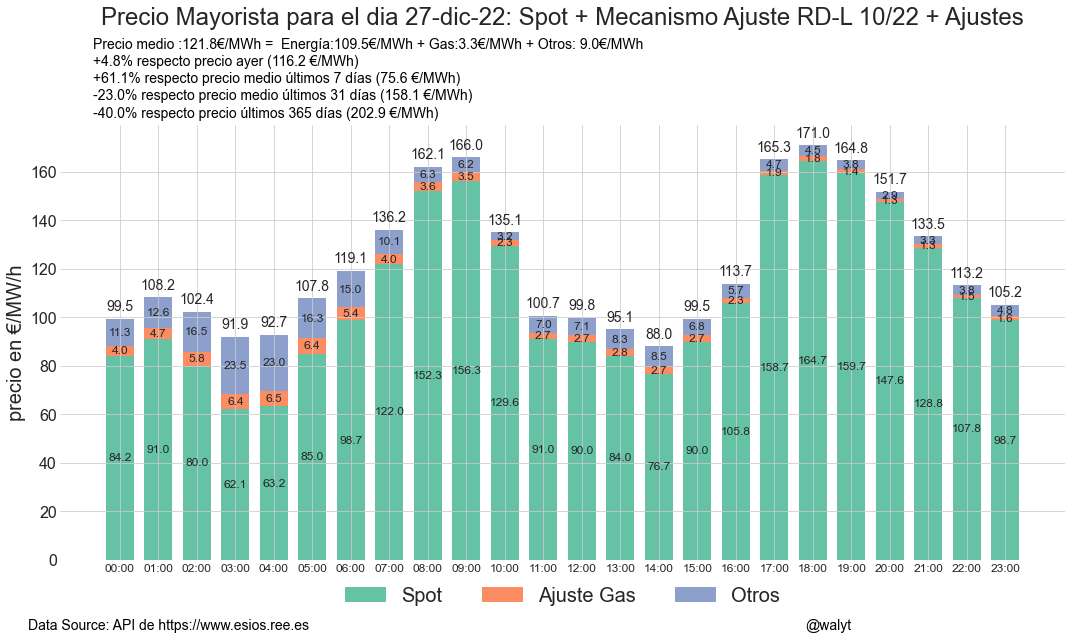

In [39]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')
titulo_fecha = (date.today()).strftime('%d-%b-%y')


bar1=ax.bar(
    data=mayorista.loc[mayorista['tipo']==lista_indicadores[0],:],
    x='hora', height='precio',width=.03,
    color=color_ind[lista_indicadores[0]],
    bottom=0,
    lw=0
    )

bar2=ax.bar(
    data=mayorista.loc[mayorista['tipo']==lista_indicadores[1],:],
    x='hora', height='precio',width=.03,
    color=color_ind[lista_indicadores[1]],
    lw=0,
    bottom=mayorista.loc[mayorista['tipo']==lista_indicadores[0],'precio'].values
)

bar3=ax.bar(
    data=mayorista.loc[mayorista['tipo']==lista_indicadores[2],:],
    x='hora', height='precio',width=.03,
    color=color_ind[lista_indicadores[2]],
    lw=0,
    bottom=mayorista.query(f"tipo in ['{lista_indicadores[1]}','{lista_indicadores[0]}']").groupby('hora').sum()['precio'].values
)

for i,rect in enumerate(bar1.patches):
            filtro_ind_max = lista_indicadores
            filtro_ind_min = lista_indicadores[1:]
            valor = rect.get_height()
            height = (valor)/2
            ax.text(rect.get_x()+rect.get_width()/2, height,f'{valor:0.1f}',ha='center', va='center',fontsize=12)
           
for i,rect in enumerate(bar2.patches):
            
            base = rect.get_xy()[1]
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2, base+height/2,f'{height:0.1f}',ha='center', va='center',fontsize=12)

for i,rect in enumerate(bar3.patches):
            
            base = rect.get_xy()[1]
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2, base+height/2,f'{height:0.1f}',ha='center', va='center',fontsize=12)
            
for i,rect in enumerate(bar1.patches):
            
            base = rect.get_xy()[1]
            height = mayorista.groupby('hora').sum()['precio'].values[i]
            ax.text(rect.get_x()+rect.get_width()/2, height+5,f'{height:0.1f}',ha='center', va='center',fontsize=14)



ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x: f'{v:.0f}'))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MW/h',fontsize=20)

ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:02d}:00'.format(v)))

x_labels = [(date2num(i),pd.to_datetime(i).strftime('%H:%M')) for i in mayorista['hora'].unique()]
ax.set_xticks([i[0] for i in x_labels])
ax.set_xticklabels([i[1] for i in x_labels])



leyenda_gas = mpatches.Patch(color=color_ind['Ajuste Gas'],label='Ajuste Gas')
leyenda_energia = mpatches.Patch(color=color_ind['Spot'],label='Spot')
leyenda_otros = mpatches.Patch(color=color_ind['Otros'],label='Otros')

plt.legend(handles=[leyenda_energia,leyenda_gas,leyenda_otros],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)


ax.set_title(f'Precio Mayorista para el dia {titulo_fecha}: Spot + Mecanismo Ajuste RD-L 10/22 + Ajustes',fontsize=24,pad=100)
media_gas = mayorista[mayorista['tipo']==lista_indicadores[1]]['precio'].mean()
media_spot = mayorista[mayorista['tipo']==lista_indicadores[0]]['precio'].mean()
media_otros = mayorista[mayorista['tipo']==lista_indicadores[2]]['precio'].mean()
media_total = mayorista.groupby('hora').sum()['precio'].mean()

f.text(0.15, 1.02, f'Precio medio :{media_total:,.1f}€/MWh =  Energía:{media_spot:,.1f}€/MWh + Gas:{media_gas:,.1f}€/MWh + Otros: {media_otros:,.1f}€/MWh', horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')

f.text(0.15, .99, f'{media_total/ayer_media-1:+,.1%} respecto precio ayer ({ayer_media:,.1f} €/MWh)',
       horizontalalignment='left',
       verticalalignment='center',
       fontsize=14,color='black')
f.text(0.15, .96, f'{media_total/semana_media-1:+,.1%} respecto precio medio últimos 7 días ({semana_media:,.1f} €/MWh)',
       horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')
f.text(0.15, .93, f'{media_total/mes_media-1:+,.1%} respecto precio medio últimos 31 días ({mes_media:,.1f} €/MWh)',
       horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')
f.text(0.15, .9, f'{media_total/anno_media-1:+,.1%} respecto precio últimos 365 días ({anno_media:,.1f} €/MWh)', horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')


sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=14,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=14,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'

path_imagen = path_proyecto+'img/'+'mayorista_gas.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')





## Con script GCP

In [79]:
from mayorista_diario_v2 import esios_mayorista_diario

In [80]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [81]:
robot = esios_mayorista_diario(apikey_walyt,apisecretkey_walyt,AccessToken_walyt,
              AccessTokenSecret_walyt,token_esios,path_proyecto)

In [28]:
historico = robot.load_historico()

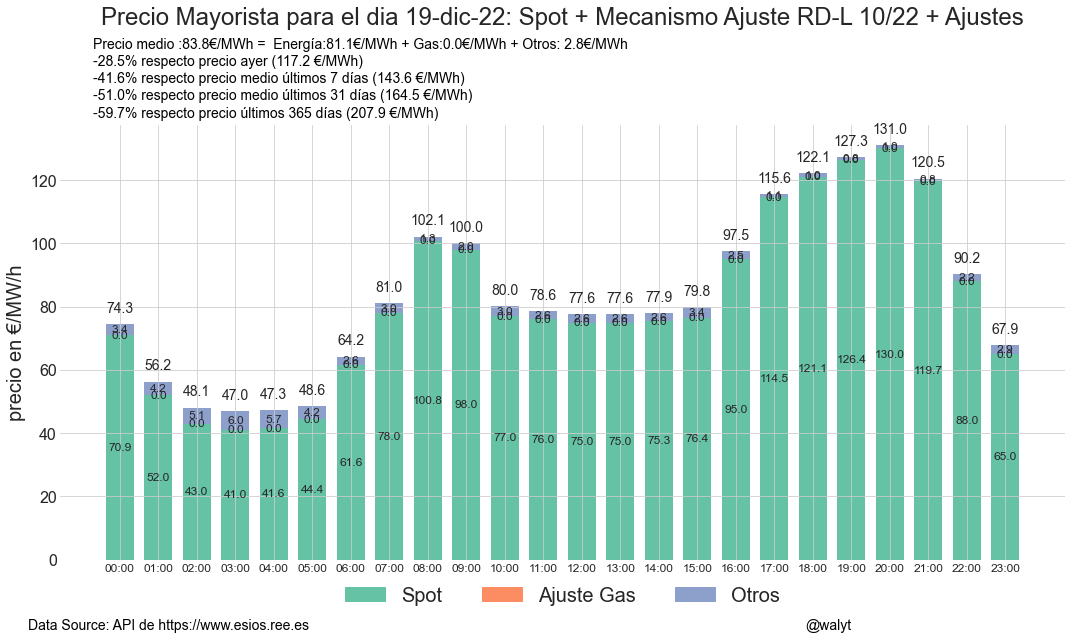

In [29]:
grafico = robot.grafico_mayorista_gas_diario()

In [8]:
hoy = date.today().strftime('%d de %B')

In [9]:
texto = f"Precio mayorista de {hoy}:\n"
texto += f'{robot.datos_dia[0]:,.1f}€/MWh =  Energía:{robot.datos_dia[1]:,.1f} + Gas:{robot.datos_dia[2]:,.1f} + Otros: {robot.datos_dia[3]:,.1f}\n\
{1-robot.datos_historicos[0]/robot.datos_dia[0]:+,.1%} respecto precio ayer ({robot.datos_historicos[0]:,.1f})\n\
{1-robot.datos_historicos[1]/robot.datos_dia[0]:+,.1%} respecto precio medio últimos 7 días ({robot.datos_historicos[1]:,.1f})\n\
{1-robot.datos_historicos[2]/robot.datos_dia[0]:+,.1%} respecto precio medio últimos 31 días ({robot.datos_historicos[2]:,.1f})\n\
{1-robot.datos_historicos[3]/robot.datos_dia[0]:+,.1%} respecto precio últimos 365 días ({robot.datos_historicos[3]:,.1f})\n'

In [31]:
texto = f"Precio mayorista de {hoy}:\n"
texto += f'{robot.datos_dia[0]:,.1f}€/MWh =  Energía:{robot.datos_dia[1]:,.1f} + Gas:{robot.datos_dia[2]:,.1f} + Otros: {robot.datos_dia[3]:,.1f}\n\
{robot.datos_dia[0]/robot.datos_historicos[0]-1:+,.1%} respecto precio ayer ({robot.datos_historicos[0]:,.1f})\n\
{robot.datos_dia[0]/robot.datos_historicos[1]-1:+,.1%} respecto precio medio últimos 7 días ({robot.datos_historicos[1]:,.1f})\n\
{robot.datos_dia[0]/robot.datos_historicos[2]-1:+,.1%} respecto precio medio últimos 31 días ({robot.datos_historicos[2]:,.1f})\n\
{robot.datos_dia[0]/robot.datos_historicos[3]-1:+,.1%} respecto precio últimos 365 días ({robot.datos_historicos[3]:,.1f})'

In [32]:
print (texto)

Precio mayorista de 2022-12-19:
83.8€/MWh =  Energía:81.1 + Gas:0.0 + Otros: 2.8
-28.5% respecto precio ayer (117.2)
-41.6% respecto precio medio últimos 7 días (143.6)
-49.0% respecto precio medio últimos 31 días (164.5)
-59.7% respecto precio últimos 365 días (207.9)


In [34]:
robot.enviar_tweet(grafico,texto)

Status(ID=1604522476020678658, ScreenName=walyt, Created=Sun Dec 18 17:02:23 +0000 2022, Text='Precio mayorista de 18 de diciembre:\n114.2€/MWh =  Energía:97.7 + Gas:7.1 + Otros: 9.4\n-27.1% respecto precio ayer… https://t.co/0L89tFgFwE')

# Estimación día siguiente



https://www.esios.ree.es/es/analisis/10211?vis=1&start_date=18-12-2022T00%3A00&end_date=18-12-2022T23%3A00&compare_start_date=17-12-2022T00%3A00&groupby=hour&compare_indicators=805,806,807,808,809,810,811,812,813,814,815,816,1277,10403,1286,1368

In [34]:
inicio = (date.today()-timedelta(days=364))
hoy = date.today()

In [35]:
indicadores = [805]#,806,807,808,809,810,811,812,813,814,815,816,1277,10403,1286,1368]

In [36]:
raw_spot_historico = download_esios(token_esios,indicadores,inicio.strftime('%Y-%m-%d'),hoy.strftime('%Y-%m-%d'),time_trunc='day')

In [37]:
historico = (raw_spot_historico
 .assign(tipo = lambda df_: df_['short_name'].map(lambda x: 'Spot' if x=='Mercado Diario' else 'Ajuste Gas' if x=='Mecanismo de ajuste RD-L 10/2022' else 'Otros'))
 .assign(hora=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(precio = lambda df_: df_['value']/24)
 .loc[:,['hora','tipo','precio']]
 .groupby(['hora','tipo'])
 .sum()
 .reset_index()
)

In [38]:
historico.groupby(['hora']).sum().reset_index()

,hora,precio
0,2021-12-20,339.839167
1,2021-12-21,327.379583
2,2021-12-22,360.024167
3,2021-12-23,383.672500
4,2021-12-24,311.016667
...,...,...
360,2022-12-15,131.312917
361,2022-12-16,128.615833
362,2022-12-17,133.822500
363,2022-12-18,97.734167


In [39]:
historico.groupby(['hora']).sum().reset_index()['precio'].mean()

173.96384132420093

In [40]:
anno_media = historico.groupby(['hora']).sum().reset_index()['precio'].mean()

In [41]:
ayer_media =  historico.groupby(['hora']).sum().reset_index().iloc[-1]['precio']

In [42]:
mes_media = historico.groupby(['hora']).sum().reset_index().iloc[-31:]['precio'].mean()

In [43]:
semana_media = historico.groupby(['hora']).sum().reset_index().iloc[-7:]['precio'].mean()

In [44]:
ayer_media,semana_media, mes_media, anno_media

(81.06833333333334, 107.37470238095239, 122.83775537634409, 173.96384132420093)

In [45]:
manana = date.today()+timedelta(days=1)

y bajamos los de mañana

In [46]:
raw_spot = download_esios(token_esios,indicadores,manana.strftime('%Y-%m-%d'),manana.strftime('%Y-%m-%d'),time_trunc='hour')

In [47]:
raw_spot['short_name'].unique()

array(['Mercado Diario'], dtype=object)

In [48]:
colores = sns.color_palette('Set2',8)
color_ind = {'Ajuste Gas':colores[1],'Spot':colores[0],'Otros':colores[2]}
lista_indicadores=['Spot','Ajuste Gas','Otros']

In [49]:
mayorista = (raw_spot
 .assign(tipo = lambda df_: df_['short_name'].map(lambda x: 'Spot' if x=='Mercado Diario' else 'Ajuste Gas' if x=='Mecanismo de ajuste RD-L 10/2022' else 'Otros'))
 .assign(hora=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(precio = lambda df_: df_['value'])
 .loc[:,['hora','tipo','precio']]
 .groupby(['hora','tipo'])
 .sum()
 .reset_index()
)

In [50]:
mayorista['tipo']

0     Spot
1     Spot
2     Spot
3     Spot
4     Spot
5     Spot
6     Spot
7     Spot
8     Spot
9     Spot
10    Spot
11    Spot
12    Spot
13    Spot
14    Spot
15    Spot
16    Spot
17    Spot
18    Spot
19    Spot
20    Spot
21    Spot
22    Spot
23    Spot
Name: tipo, dtype: object

In [51]:
mayorista.query(f"tipo in ['{lista_indicadores[1]}','{lista_indicadores[0]}']").groupby('hora').sum()['precio'].values

array([ 44.08,   8.  ,   4.11,   4.11,   4.11,   5.04,  10.  ,  64.  ,
        92.  ,  94.93,  91.78,  89.21,  89.21,  81.14,  75.  ,  89.21,
        92.16, 100.9 , 101.97, 107.  , 101.97,  95.  ,  75.  ,  49.83])

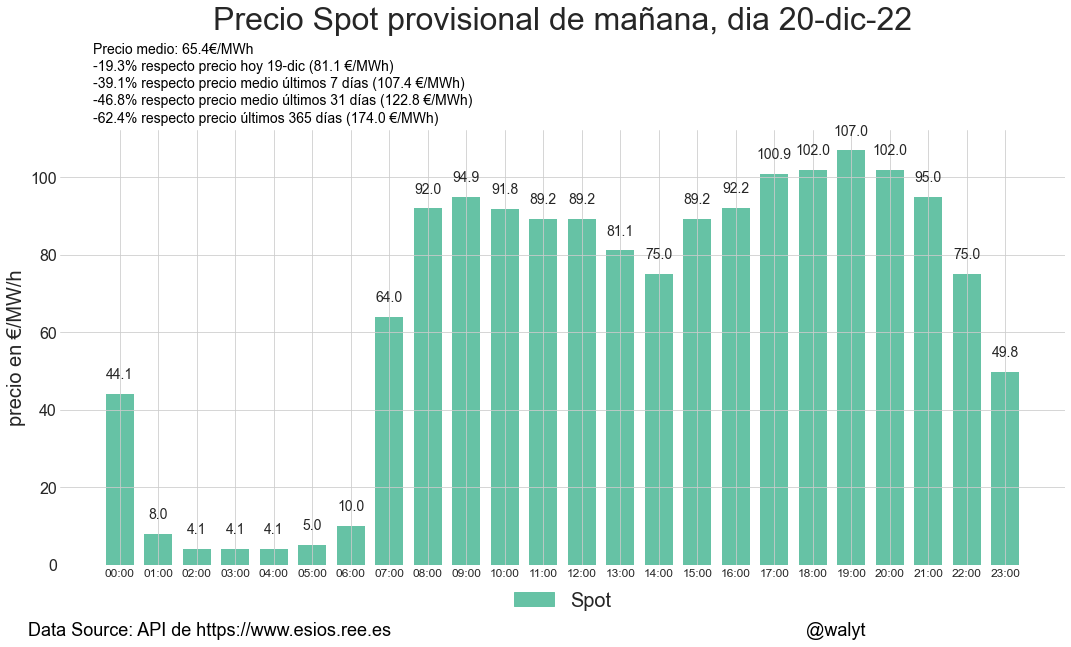

In [52]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')
titulo_fecha = (date.today()+timedelta(days=1)).strftime('%d-%b-%y')
ayer = (date.today()).strftime('%-d-%b') #es para el dia d+1, luego ayer es hoy

bar1=ax.bar(
    data=mayorista.loc[mayorista['tipo']==lista_indicadores[0],:],
    x='hora', height='precio',width=.03,
    color=color_ind[lista_indicadores[0]],
    bottom=0,
    lw=0
    )
            
for i,rect in enumerate(bar1.patches):
            
    base = rect.get_xy()[1]
    height = mayorista.groupby('hora').sum()['precio'].values[i]
    ax.text(rect.get_x()+rect.get_width()/2, height+5,f'{height:0.1f}',ha='center', va='center',fontsize=14)



ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x: f'{v:.0f}'))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MW/h',fontsize=20)

ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:02d}:00'.format(v)))

x_labels = [(date2num(i),pd.to_datetime(i).strftime('%H:%M')) for i in mayorista['hora'].unique()]
ax.set_xticks([i[0] for i in x_labels])
ax.set_xticklabels([i[1] for i in x_labels])




leyenda_energia = mpatches.Patch(color=color_ind['Spot'],label='Spot')

plt.legend(handles=[leyenda_energia],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)


ax.set_title(f'Precio Spot provisional de mañana, dia {titulo_fecha}',fontsize=32
             ,pad=100)

media_total = mayorista.groupby('hora').sum()['precio'].mean()

f.text(0.15, 1.02, f'Precio medio: {media_total:,.1f}€/MWh', horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')

f.text(0.15, .99, f'{media_total/ayer_media-1:+,.1%} respecto precio hoy {ayer} ({ayer_media:,.1f} €/MWh)',
       horizontalalignment='left',
       verticalalignment='center',
       fontsize=14,color='black')
f.text(0.15, .96, f'{media_total/semana_media-1:+,.1%} respecto precio medio últimos 7 días ({semana_media:,.1f} €/MWh)',
       horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')
f.text(0.15, .93, f'{media_total/mes_media-1:+,.1%} respecto precio medio últimos 31 días ({mes_media:,.1f} €/MWh)',
       horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')
f.text(0.15, .9, f'{media_total/anno_media-1:+,.1%} respecto precio últimos 365 días ({anno_media:,.1f} €/MWh)', horizontalalignment='left',
             verticalalignment='center', fontsize=14,color='black')


sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=18,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=18,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'

path_imagen = path_proyecto+'img/'+'mayorista_spot_d1.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')

## Con script GCP

In [53]:
from mayorista_diario_d1 import esios_mayorista_diario_d1

In [54]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [55]:
robot = esios_mayorista_diario_d1(apikey_walyt,apisecretkey_walyt,AccessToken_walyt,
              AccessTokenSecret_walyt,token_esios,path_proyecto)

In [56]:
historico = robot.load_historico()

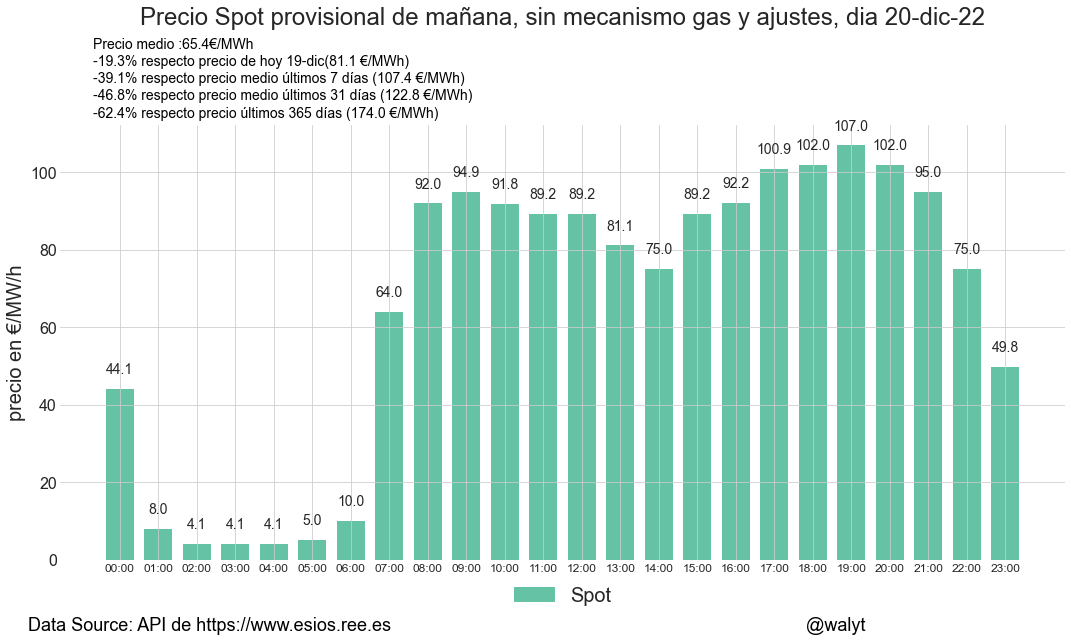

In [57]:
grafico = robot.grafico_mayorista_gas_diario()

In [168]:
ayer = date.today().strftime('%d de %B')

In [58]:
texto = f"Precio mayorista provisional (solo spot) de mañana {manana}: "
texto += f'{robot.datos_dia:,.1f}€/MWh\n{robot.datos_dia/robot.datos_historicos[0]-1:+,.1%} respecto precio de hoy {ayer} ({robot.datos_historicos[0]:,.1f})\n{robot.datos_dia/robot.datos_historicos[1]-1:+,.1%} respecto precio medio últimos 7 días ({robot.datos_historicos[1]:,.1f})\n{robot.datos_dia/robot.datos_historicos[2]-1:+,.1%} respecto precio medio últimos 31 días ({robot.datos_historicos[2]:,.1f})\n{robot.datos_dia/robot.datos_historicos[3]-1:+,.1%} respecto precio últimos 365 días ({robot.datos_historicos[3]:,.1f})\n'

In [59]:
print (texto)

Precio mayorista provisional (solo spot) de mañana 2022-12-20: 65.4€/MWh
-19.3% respecto precio de hoy 19-dic (81.1)
-39.1% respecto precio medio últimos 7 días (107.4)
-46.8% respecto precio medio últimos 31 días (122.8)
-62.4% respecto precio últimos 365 días (174.0)



In [17]:
len(texto)

251

In [ ]:
robot.enviar_tweet(grafico,texto)

# análisis mayorista + gas en un día

In [5]:
# 10211 : Precio medio horario final suma de componentes
# 883 --- Precio medio mensual componente mercado diario
# 549: Generación T.Real nuclear
# 600 : mayorista

In [6]:
fin = date.today().strftime('%Y-%m-%d')
fin_titulo = date.today().strftime('%-d-%b')

inicio = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')
inicio_titulo = (date.today()-timedelta(days=1)).strftime('%-d-%b')

In [7]:
datetime.strptime(inicio,'%Y-%m-%d').strftime('%-d-%b')

'16-Dec'

In [8]:
url_compuesta = f'{url}/10211?start_date={inicio}T00:00&end_date={inicio}T23:59&time_trunc=hour'

In [9]:
response = requests.get(url_compuesta, headers=headers).json()

In [10]:
mayorista = pd.DataFrame()
for dato in response['indicator']['values']:
    if dato['geo_name']=='Península':
        dt = datetime.fromisoformat(dato['datetime'])
        fecha = date(year=dt.year,month=dt.month,day=dt.day)
        mayorista = pd.concat([mayorista,pd.DataFrame([{'fecha':fecha,'hora':dt.hour,'coste':dato['value'],'indicador':'Precio final'}])]).reset_index(drop=True)

El end point es 10403 : es el que coincide con https://www.esios.ree.es/es/mercados-y-precios?date=15-07-2022

In [11]:
url_compuesta = f'{url}/10403?start_date={inicio}T00:00&end_date={inicio}T23:59&time_trunc=hour'
#url_compuesta = f'{url}/10403?start_date=2022-07-12T00:00&end_date=2022-07-12T23:59&time_trunc=hour'

In [12]:
response = requests.get(url_compuesta, headers=headers).json()

In [13]:
response['indicator']['values_updated_at']

'2022-12-17T07:52:37.000+01:00'

In [14]:
for dato in response['indicator']['values']:
    if dato['geo_name']=='Península':
        dt = datetime.fromisoformat(dato['datetime'])
        fecha = date(year=dt.year,month=dt.month,day=dt.day)
        mayorista = pd.concat([mayorista,pd.DataFrame([{'fecha':fecha,'hora':dt.hour,'coste':dato['value'],'indicador':'ajuste gas'}])])
mayorista.reset_index(inplace=True,drop=True)       

In [15]:
def cambia_signo(df,signo):
    df.loc[df.indicador=='ajuste gas','coste'] = (df.loc[df.indicador=='ajuste gas','coste'] * (signo))
    return df

In [16]:
mayorista = pd.concat([mayorista,mayorista.pipe(cambia_signo,(-1)).groupby(['fecha','hora']).sum().reset_index().assign(indicador='Spot')]).pipe(cambia_signo,(-1))


In [208]:
ax.set_xticks(date2num(mayorista['hora'].unique()))

NameError: name 'date2num' is not defined

In [18]:
colores = sns.color_palette('Set2',8)
color_ind = {'ajuste gas':colores[1],'Spot':colores[0]}
lista_indicadores=['Spot','ajuste gas']

In [19]:
mayorista = mayorista.loc[mayorista['indicador']!='Precio final',:]

NameError: name 'ayer_titulo' is not defined

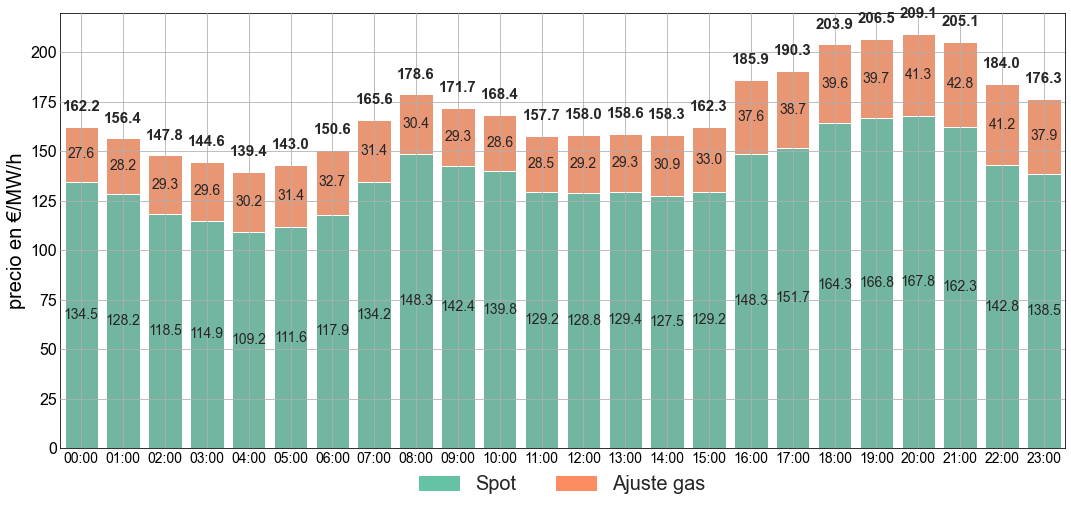

In [20]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')



bar1=sns.barplot(
    data=mayorista,
    x='hora', y='coste',ci=None,estimator=sum,color=color_ind[lista_indicadores[1]]
    )

for i,rect in enumerate(bar1.patches):
            filtro_ind_max = lista_indicadores
            filtro_ind_min = lista_indicadores[1:]
            valor = mayorista.loc[(mayorista['hora']==i) & (mayorista['indicador']=='Spot')]['coste'].sum()
            height = (valor)/2
            ax.text(rect.get_x()+rect.get_width()/2, height,f'{valor:0.1f}',ha='center', va='center',fontsize=14)
            
for i,rect in enumerate(bar1.patches):
            vmin = mayorista.loc[(mayorista['hora']==i) & (mayorista['indicador']=='Spot')]['coste'].sum()
            vmax = mayorista.loc[(mayorista['hora']==i) & (mayorista['indicador']=='ajuste gas')]['coste'].sum()
            valor = mayorista.loc[(mayorista['hora']==i) & (mayorista['indicador']=='ajuste gas')]['coste'].sum()
            height = vmin+(vmax)/2
            ax.text(rect.get_x()+rect.get_width()/2, height,f'{valor:0.1f}',ha='center', va='center',fontsize=14)
            
for i,rect in enumerate(bar1.patches):
            
            valor = mayorista.loc[(mayorista['hora']==i)]['coste'].sum()
            height = valor+10
            ax.text(rect.get_x()+rect.get_width()/2, height,f'{valor:0.1f}',ha='center', va='center',fontsize=15,weight='bold')


            
            
bar2=sns.barplot(
    data=mayorista[mayorista['indicador']==lista_indicadores[0]],
    x='hora', y='coste',ci=None,estimator=sum,color=color_ind[lista_indicadores[0]])


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x: f'{v:.0f}'))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MW/h',fontsize=20)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=16,width=0,rotation=0,pad=0)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:02d}:00'.format(v)))


leyenda_energia = mpatches.Patch(color=color_ind['ajuste gas'],label='Ajuste gas')
leyenda_gas = mpatches.Patch(color=color_ind['Spot'],label='Spot')
plt.legend(handles=[leyenda_gas,leyenda_energia],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)


ax.set_title(f'Precio spot + ajuste gas (Mecanismo Ajuste RD-L 10/22) por horas para el dia {ayer_titulo}',fontsize=24,pad=30)
media_gas = mayorista[mayorista['indicador']==lista_indicadores[1]]['coste'].mean()
media_spot = mayorista[mayorista['indicador']==lista_indicadores[0]]['coste'].mean()
media_total = mayorista.groupby('hora').sum()['coste'].mean()

f.text(0.1, .9, f'Precio medio Ajuste Gas:{media_gas:,.1f}, Precio medio Energía:{media_spot:,.1f} Precio medio Total:{media_total:,.1f}', horizontalalignment='left',
             verticalalignment='center', fontsize=12,color='black')
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=14,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=14,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'
path_imagen = path_proyecto+'img/'+'mayorista_gas.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')




# Históricos del spot y ajuste gas

In [19]:
inicio = '2021-01-01'
fin = date.today().strftime('%Y-%m-%d')
fin_titulo = date.today().strftime('%-d-%b')
ayer = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')
ayer_titulo = (date.today()-timedelta(days=1)).strftime('%-d-%b')
url_compuesta = f'{url}/10211?start_date={inicio}T00:00&end_date={ayer}T23:59&time_trunc=day'

In [20]:
response = requests.get(url_compuesta, headers=headers).json()

In [21]:
df=pd.DataFrame()
for dato in response['indicator']['values']:
    if dato['geo_name']=='Península':
        dt = datetime.fromisoformat(dato['datetime']).replace(tzinfo=None)
        fecha = date(year=dt.year,month=dt.month,day=dt.day)
        df = pd.concat([df,pd.DataFrame([{'fecha':dt,'hora':dt.hour,'coste':dato['value'],'indicador':'Precio final'}])]).reset_index(drop=True)

In [22]:
#df['coste'] = df['coste']/24

In [23]:
url_compuesta = f'{url}/10403?start_date={inicio}T00:00&end_date={ayer}T23:59&time_trunc=day'

In [24]:
response = requests.get(url_compuesta, headers=headers).json()

In [25]:
for dato in response['indicator']['values']:
    if dato['geo_name']=='Península':
        dt = datetime.fromisoformat(dato['datetime']).replace(tzinfo=None)
        fecha = date(year=dt.year,month=dt.month,day=dt.day)
        df = pd.concat([df,pd.DataFrame([{'fecha':dt,'hora':dt.hour,'coste':dato['value'],'indicador':'ajuste gas'}])])
df.reset_index(inplace=True,drop=True)       

In [26]:
df['coste'] = df['coste']/24

In [27]:
df.index

RangeIndex(start=0, stop=712, step=1)

In [28]:
df['fecha'] = pd.to_datetime(df['fecha'],utc=False)

In [29]:
df

,fecha,hora,coste,indicador
0,2021-01-01,0,49.130417,Precio final
1,2021-01-02,0,54.157917,Precio final
2,2021-01-03,0,53.487917,Precio final
3,2021-01-04,0,67.423750,Precio final
4,2021-01-05,0,74.886250,Precio final
...,...,...,...,...
707,2022-07-19,0,49.997083,ajuste gas
708,2022-07-20,0,54.391667,ajuste gas
709,2022-07-21,0,58.543333,ajuste gas
710,2022-07-22,0,56.147083,ajuste gas


In [32]:
df = pd.concat([df,df.pipe(cambia_signo,(-1)).groupby(['fecha','hora']).sum().reset_index().assign(indicador='Spot')]).pipe(cambia_signo,(-1))

In [19]:
df = df.loc[df['indicador']!='Precio final',:]

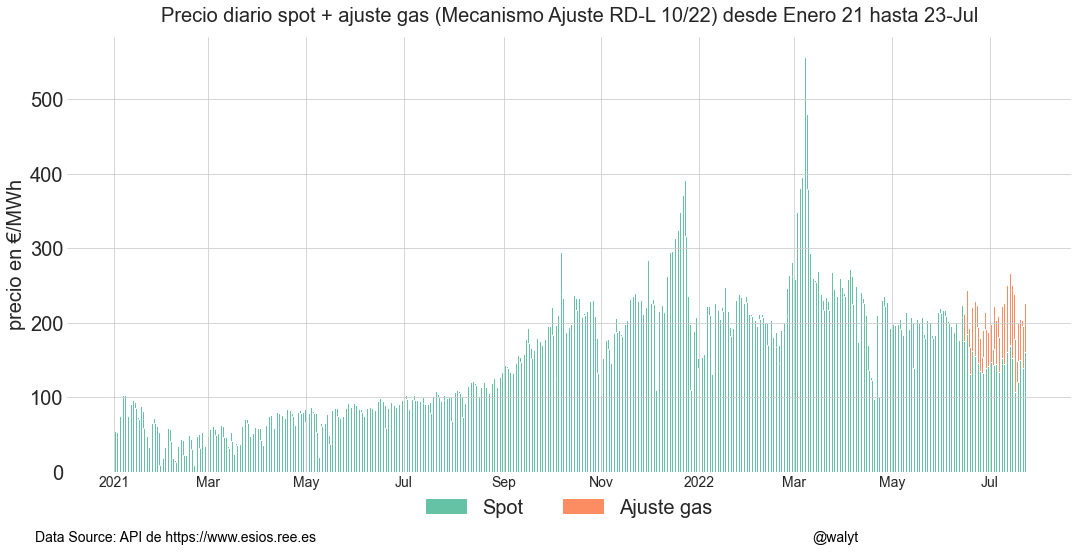

In [692]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')

df['eje_x'] = df['fecha'].apply ( lambda x:x.strftime('%b-%y'))

#bar1=plt.bar(x=df['fecha'], height=df['coste'],color=color_ind[lista_indicadores[1]])
plt.bar(x=df.loc[df['indicador']==lista_indicadores[0],'fecha'],height= df.loc[df['indicador']==lista_indicadores[0],'coste'],width=1.2,color=color_ind[lista_indicadores[0]])

plt.bar(x=df.loc[df['indicador']==lista_indicadores[1],'fecha'],height= df.loc[df['indicador']==lista_indicadores[1],'coste'],
             color=color_ind[lista_indicadores[1]],width=1.2,
        bottom=df.loc[(df['indicador']==lista_indicadores[0]) & (df['fecha'].isin(df.loc[df['indicador']==lista_indicadores[1],'fecha'])),'coste'])



ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.0f}'.format(v)))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MWh',fontsize=20)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)

ax.set_axisbelow(False)


#locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#ax.xaxis.set_major_formatter(DateFormatter('%-d-%b-%y'))


locator = mdates.AutoDateLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))

'''locator = mdates.YearLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
'''

'''ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,2,3,4,5,6,7,8,9,10,11,12],bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
'''
leyenda_energia = mpatches.Patch(color=color_ind['ajuste gas'],label='Ajuste gas')
leyenda_gas = mpatches.Patch(color=color_ind['Spot'],label='Spot')
plt.legend(handles=[leyenda_gas,leyenda_energia],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)




ax.set_title(f'Precio diario spot + ajuste gas (Mecanismo Ajuste RD-L 10/22) desde Enero 21 hasta {ayer_titulo}',fontsize=20,pad=15)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=14,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=14,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'
path_imagen = path_proyecto+'img/'+'historico_mayorista.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')





In [10]:
df_draw = df.groupby([pd.Grouper(key='fecha',freq='W'),'indicador']).mean().reset_index()

NameError: name 'df' is not defined

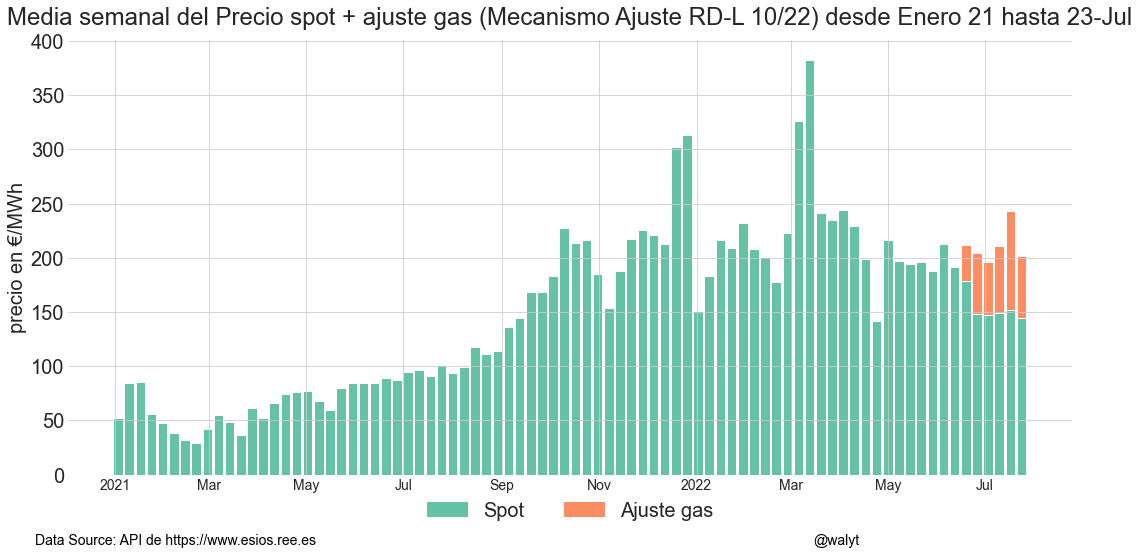

In [694]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')

df_draw['eje_x'] = df_draw['fecha'].apply ( lambda x:x.strftime('%b-%y'))

plt.bar(x=df_draw.loc[df_draw['indicador']==lista_indicadores[0],'fecha'],height= df_draw.loc[df_draw['indicador']==lista_indicadores[0],'coste'],
        width=6,color=color_ind[lista_indicadores[0]])

plt.bar(x=df_draw.loc[df_draw['indicador']==lista_indicadores[1],'fecha'],height= df_draw.loc[df_draw['indicador']==lista_indicadores[1],'coste'],
             color=color_ind[lista_indicadores[1]],width=6,
        bottom=df_draw.loc[(df_draw['indicador']==lista_indicadores[0]) & (df_draw['fecha'].isin(df_draw.loc[df_draw['indicador']==lista_indicadores[1],'fecha'])),'coste'])



ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.0f}'.format(v)))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MWh',fontsize=20)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)

ax.set_axisbelow(False)

locator = mdates.AutoDateLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))


#locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#ax.xaxis.set_major_formatter(DateFormatter('%-d-%b-%y'))


'''locator = mdates.AutoDateLocator()
locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(DateFormatter('%b'))

'''
'''locator = mdates.YearLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
'''

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

leyenda_energia = mpatches.Patch(color=color_ind['ajuste gas'],label='Ajuste gas')
leyenda_gas = mpatches.Patch(color=color_ind['Spot'],label='Spot')
plt.legend(handles=[leyenda_gas,leyenda_energia],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)




ax.set_title(f'Media semanal del Precio spot + ajuste gas (Mecanismo Ajuste RD-L 10/22) desde Enero 21 hasta {ayer_titulo}',fontsize=24,pad=15)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=14,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=14,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'
path_imagen = path_proyecto+'img/'+'historico_mayorista_semanal.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')





In [695]:
df_draw = df.groupby([pd.Grouper(key='fecha',freq='M'),'indicador']).mean().reset_index()
df_draw['fecha'] = df_draw['fecha'].apply(lambda x:x.replace(day=1))

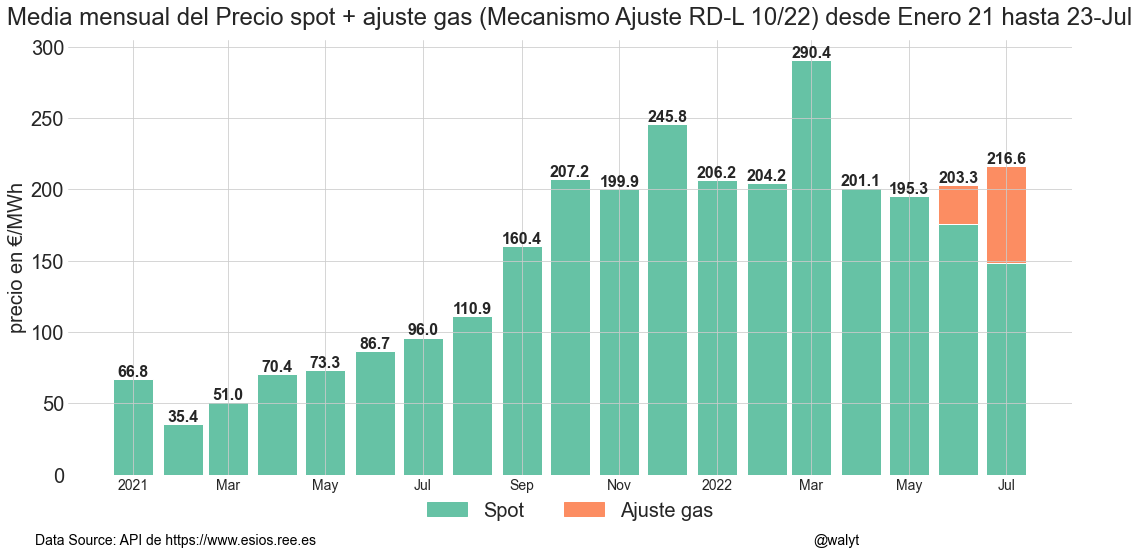

In [696]:
f, ax = plt.subplots(figsize=(18, 8))
geo='Península'
fuente = 'API de https://www.esios.ree.es'
autor = '@walyt'
sns.set_style(style='white')

df_draw['eje_x'] = df_draw['fecha'].apply ( lambda x:x.strftime('%b-%y'))

total = plt.bar(x=df_draw.loc[df_draw['indicador']==lista_indicadores[0],'fecha'],height= df_draw.loc[df_draw['indicador']==lista_indicadores[0],'coste'],
        width=25,color=color_ind[lista_indicadores[0]])

spot = plt.bar(x=df_draw.loc[df_draw['indicador']==lista_indicadores[1],'fecha'],height= df_draw.loc[df_draw['indicador']==lista_indicadores[1],'coste'],
             color=color_ind[lista_indicadores[1]],width=25,
        bottom=df_draw.loc[(df_draw['indicador']==lista_indicadores[0]) & (df_draw['fecha'].isin(df_draw.loc[df_draw['indicador']==lista_indicadores[1],'fecha'])),'coste'])

valores = df_draw.groupby(['fecha']).sum().reset_index(drop=True)['coste']
for i,rect in enumerate(total.patches):
    
    ax.text(rect.get_x()+rect.get_width()/2, valores[i]+5,'{:0.1f}'.format(valores[i]),ha='center', va='center',fontsize=16,weight='bold')



ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.0f}'.format(v)))
ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('precio en €/MWh',fontsize=20)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=20,width=0,rotation=0,pad=0)

ax.set_axisbelow(False)

locator = mdates.AutoDateLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))


#locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#ax.xaxis.set_major_formatter(DateFormatter('%-d-%b-%y'))


'''locator = mdates.AutoDateLocator()
locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(DateFormatter('%b'))

'''
'''locator = mdates.YearLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
'''

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

leyenda_energia = mpatches.Patch(color=color_ind['ajuste gas'],label='Ajuste gas')
leyenda_gas = mpatches.Patch(color=color_ind['Spot'],label='Spot')
plt.legend(handles=[leyenda_gas,leyenda_energia],fontsize=20,
           loc=9,ncol=5,bbox_to_anchor=(.5,-.02),frameon=False)

ax.set_axisbelow(False)




ax.set_title(f'Media mensual del Precio spot + ajuste gas (Mecanismo Ajuste RD-L 10/22) desde Enero 21 hasta {ayer_titulo}',fontsize=24,pad=15)
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)
f.text(0.1, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
    verticalalignment='center', fontsize=14,color='black')
f.text(0.7,0.01,'{}'.format(autor),
    verticalalignment='center',fontsize=14,horizontalalignment='left',color='black')
#path_imagen = path_dir_imagenes+'coste_hora_'+geo+'.png'
path_imagen = path_proyecto+'img/'+'historico_mayorista_mensual.png'
f.savefig(path_imagen,dpi=288,bbox_inches='tight')




In [39]:
for i,rect in enumerate(total.patches):
    
    print (rect.get_x(),rect.get_width(),rect.get_height())

18615.5 25 60.16532258064516
18646.5 25 28.492752976190477
18674.5 25 45.39106182795699
18705.5 25 65.01745833333334
18735.5 25 67.1249059139785
18766.5 25 83.29983333333332
18796.5 25 92.41538978494624
18827.5 25 105.94068548387096
18858.5 25 156.14447222222222
18888.5 25 200.16373655913978
18919.5 25 193.43079166666666
18949.5 25 239.16495967741935
18980.5 25 201.71762096774194
19011.5 25 200.21925595238096
19039.5 25 283.00864247311824
19070.5 25 191.51655555555556
19100.5 25 187.12600806451613
19131.5 25 169.62569444444446
19161.5 25 141.9592613636364


In [797]:
for i,rect in enumerate(spot.patches):
    
    print (rect.get_x(),rect.get_width(),rect.get_height())

18796.5 25 0.0
18888.5 25 0.0
19011.5 25 0.0
19131.5 25 27.52944444444445
19161.5 25 59.77442708333332


In [806]:
df_draw.groupby(['fecha']).sum().reset_index(drop=True)['coste'][0]

60.16532258064516

# Por países

In [7]:
inicio = '2021-01-01'
fin = date.today().strftime('%Y-%m-%d')
fin_titulo = date.today().strftime('%-d-%b')
ayer = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')
ayer_titulo = (date.today()-timedelta(days=1)).strftime('%-d-%b')
url_compuesta = f'{url}/600?start_date={inicio}T00:00&end_date={ayer}T23:59&time_trunc=day'

In [8]:
response = requests.get(url_compuesta, headers=headers).json()

In [9]:
mayorista = pd.DataFrame()
for dato in response['indicator']['values']:
    dt = datetime.fromisoformat(dato['datetime']).replace(tzinfo=None)
    fecha = date(year=dt.year,month=dt.month,day=dt.day)
    mayorista = pd.concat([mayorista,pd.DataFrame([{'fecha':dt,'coste':dato['value'],'geo':dato['geo_name'],'indicador':'mayorista'}])]).reset_index(drop=True)
mayorista['coste'] = mayorista['coste']/24

In [10]:
mayorista

,fecha,coste,geo,indicador
0,2021-01-01,42.51,Portugal,mayorista
1,2021-01-01,48.40,Francia,mayorista
2,2021-01-01,42.51,España,mayorista
3,2021-01-01,68.31,Reino Unido,mayorista
4,2021-01-01,48.17,Italia,mayorista
...,...,...,...,...
5387,2022-11-06,117.93,Reino Unido,mayorista
5388,2022-11-06,122.91,Italia,mayorista
5389,2022-11-06,51.09,Alemania,mayorista
5390,2022-11-06,88.63,Bélgica,mayorista


In [11]:
url_compuesta = f'{url}/10403?start_date={inicio}T00:00&end_date={ayer}T23:59&time_trunc=day'

In [12]:
response = requests.get(url_compuesta, headers=headers).json()

In [13]:
gas = pd.DataFrame()
for dato in response['indicator']['values']:
    if dato['geo_name']=='Península':
        dt = datetime.fromisoformat(dato['datetime']).replace(tzinfo=None)
        fecha = date(year=dt.year,month=dt.month,day=dt.day)
        gas = pd.concat([gas,pd.DataFrame([{'fecha':dt,'coste':dato['value'],'indicador':'ajuste gas'}])]).reset_index(drop=True)
gas['coste'] = gas['coste'] / 24
gas['geo'] = 'España'
gas = gas.loc[gas['fecha']>='2022-06-15',:]

In [14]:
def limita_columnas(df):
    df.columns = ['coste','geo','indicador','c1','i1','g1']
    return df.loc[:,list(df.columns)[:3]]

In [15]:
mayorista_final = (
    pd.concat([pd.concat([mayorista.loc[(mayorista['geo']=='España'),:].set_index('fecha'),gas.set_index('fecha')],axis=1).
assign(coste = lambda x: x['coste'].sum(axis=1)).
    assign(geo='España con gas').
    pipe(limita_columnas).reset_index(),mayorista])
)

In [16]:
mayorista_final = (
    pd.concat([pd.concat([mayorista.loc[(mayorista['geo']=='España') & (mayorista['fecha'].isin(gas['fecha'].values)),:].set_index('fecha'),gas.set_index('fecha')],axis=1).
assign(coste = lambda x: x['coste'].sum(axis=1)).
    assign(geo='España con gas').
    pipe(limita_columnas).reset_index(),mayorista])
)

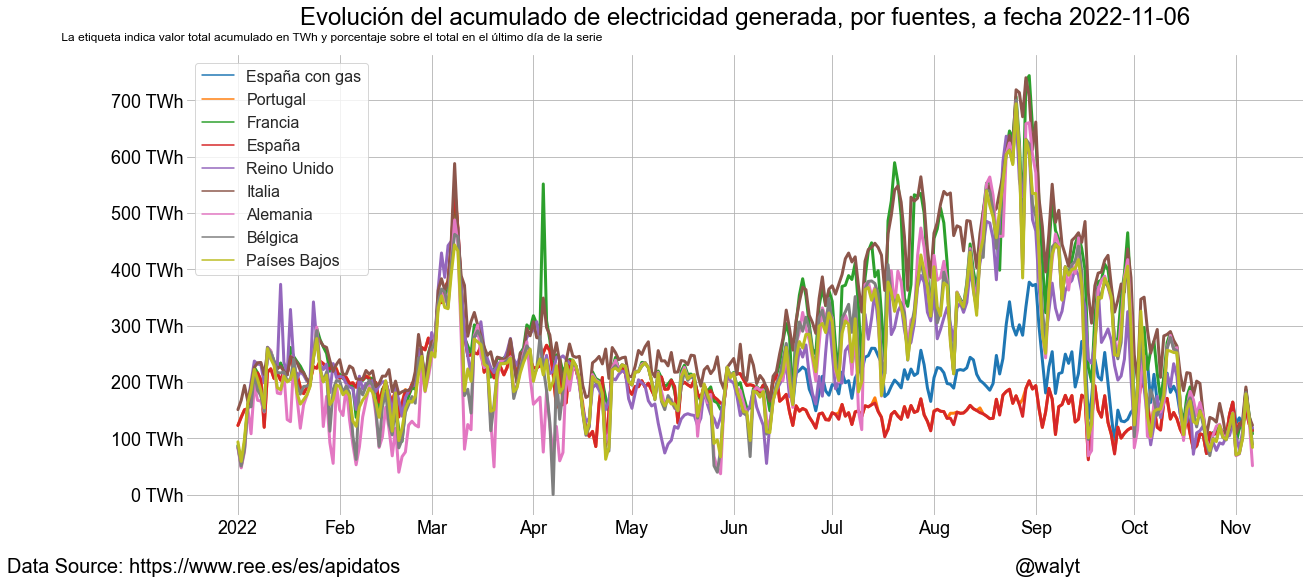

In [17]:
path_proyecto = '/Users/mharias/Documents/proyectos/consumo_luz/'
fuente = 'https://www.ree.es/es/apidatos'
autor='@walyt'
titulo = f'Evolución del acumulado de electricidad generada, por fuentes, a fecha {ayer}'
subtitulo = ' La etiqueta indica valor total acumulado en TWh y porcentaje sobre el total en el último día de la serie'


f, ax = plt.subplots(figsize=(20,8))
sns.set_style(style='white')

sns.lineplot(x='fecha', data=mayorista_final[mayorista_final['fecha']>='2022-01-01'],
             y='coste',hue='geo',ci=None,estimator=sum,ax=ax,linewidth=3)

ax.xaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

leyenda = ax.legend(fontsize=16)
#for line in leyenda.get_lines():
#    line.set_linewidth(5)
#leyenda.remove()
locator = mdates.AutoDateLocator()
#locator.intervald['DAILY'] = [1]
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f} TWh'.format(v).replace(',','.')))
sns.despine(left=True, bottom=True)
ax.grid(True)



lista_texto =[]


ax.set_xlabel('')
ax.set_ylabel('')
f.subplots_adjust(top=.9,bottom=.1)
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=30)

f.text(0.035, .93, '{}'.format(subtitulo), horizontalalignment='left',
             verticalalignment='center', fontsize=12,color='black')
f.text(0.0, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.01,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')

path_imagen = '{}img/mayorista_paises.png'.format(path_proyecto)
f.savefig(path_imagen,dpi=288,bbox_inches='tight')





In [18]:
mayorista_final.loc[mayorista_final['geo']=='España','coste'].values[-1]

113.48125

In [19]:
pd.pivot_table(index='fecha',data=mayorista_final,columns='geo')

coste                                                            \
geo        Alemania Bélgica España España con gas Francia Italia Países Bajos   
fecha                                                                           
2021-01-01    48.40   48.40  42.51            NaN   48.40  48.17        48.40   
2021-01-02    50.56   50.56  48.72            NaN   50.56  51.22        50.56   
2021-01-03    38.62   43.03  46.93            NaN   47.10  47.73        49.77   
2021-01-04    48.02   46.74  59.85            NaN   59.27  59.10        49.72   
2021-01-05    55.34   63.38  67.55            NaN   63.85  59.29        50.38   
...             ...     ...    ...            ...     ...    ...          ...   
2022-11-02    71.97   72.84 125.98         136.22  117.11 122.52        73.41   
2022-11-03   103.01  102.38 121.89         120.96  121.39 132.12        99.19   
2022-11-04   178.54  181.23 150.44         155.20  186.16 190.95       178.79   
2022-11-05   132.29  137.50 124.79         137.42  141.10 137.83       135.81   
2022-11-06    51.09   88.63 113.48         113.30  107.69 122.91        83.61   

                                 
geo        Portugal Reino Unido  
fecha                            
2021-01-01    42.51       68.31  
2021-01-02    48.72       71.45  
2021-01-03    47.16       65.18  
2021-01-04    59.85       67.42  
2021-01-05    67.55       67.70  
...             ...         ...  
2022-11-02   125.98       80.85  
2022-11-03   121.89      112.02  
2022-11-04   150.44      185.97  
2022-11-05   124.79      130.87  
2022-11-06   114.23      117.93  

[675 rows x 9 columns]

In [21]:
mayorista

,fecha,coste,geo,indicador
0,2021-01-01,42.51,Portugal,mayorista
1,2021-01-01,48.40,Francia,mayorista
2,2021-01-01,42.51,España,mayorista
3,2021-01-01,68.31,Reino Unido,mayorista
4,2021-01-01,48.17,Italia,mayorista
...,...,...,...,...
5387,2022-11-06,117.93,Reino Unido,mayorista
5388,2022-11-06,122.91,Italia,mayorista
5389,2022-11-06,51.09,Alemania,mayorista
5390,2022-11-06,88.63,Bélgica,mayorista


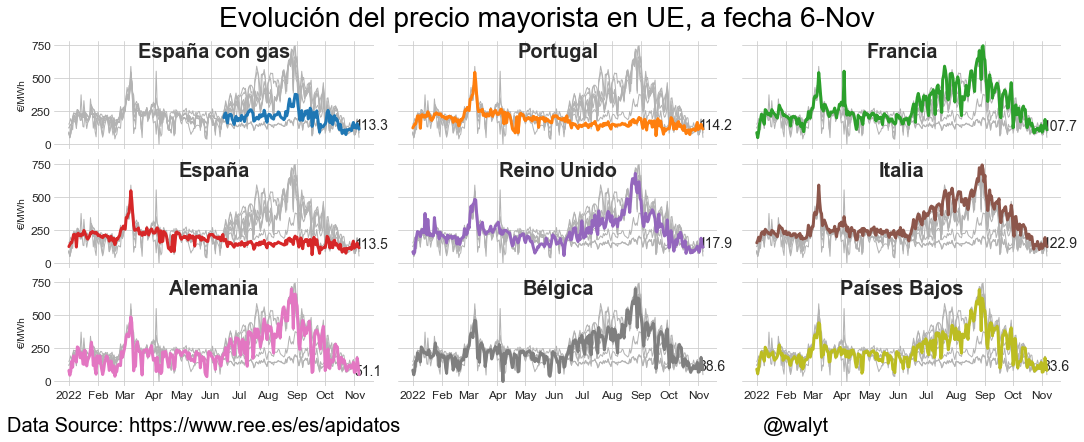

In [20]:

path_proyecto = '/Users/mharias/Documents/proyectos/consumo_luz/'
fuente = 'https://www.ree.es/es/apidatos'
autor='@walyt'
titulo = f'Evolución del precio mayorista en UE, a fecha {ayer_titulo}'

g = sns.relplot(
    data=mayorista_final[mayorista_final['fecha']>='2022-01-01'],
    x="fecha", y="coste", col="geo", hue="geo",zorder=5,
    kind="line",  linewidth=3,color='blue',
    col_wrap=3, height=2, aspect=2.5, legend=False,
)


# Iterate over each subplot to customize further
for geo, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .85, geo, transform=ax.transAxes, fontweight="bold",fontsize=20,ha='center')
    valor = mayorista_final.loc[mayorista_final['geo']==geo,'coste'].values[-1]
    xtick = ax.get_xticks()[-1]
    ax.text(xtick, valor, s=f'{valor:,.1f}',fontsize=14,ha='left')

    # Plot every year's time series in the background
    sns.lineplot(
        data=mayorista_final[mayorista_final['fecha']>='2022-01-01'], x="fecha", y="coste",units='geo',
        estimator=None, color=".7", linewidth=1, ax=ax
    )
    ax.xaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)
    ax.yaxis.set_tick_params(labelsize=12,width=0,rotation=0,pad=0)

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:,.0f}'.format(v)))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    
    locator = mdates.AutoDateLocator()
    #locator.intervald['DAILY'] = [1]
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    sns.despine(left=True, bottom=True)
    ax.grid(True)
    #ax.set_ylim((0,400000))
    #ax.set_yticks([0,.10,.2,.3,.4,.5])
    

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::1])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "€/MWh")
g.tight_layout()
g.fig.suptitle('{}'.format(titulo),fontsize=28,color='black')
g.fig.subplots_adjust(top=.9,bottom=.1)
g.fig.text(0.0, 0.01, 'Data Source: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
g.fig.text(0.7,0.01,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')
path_imagen = '{}img/rejilla_mayorista_paises.png'.format(path_proyecto)
g.savefig(path_imagen,dpi=288,bbox_inches='tight')

In [26]:
mayorista_final['geo'].unique()

array(['España con gas', 'Portugal', 'Francia', 'España', 'Reino Unido',
       'Italia', 'Alemania', 'Bélgica', 'Países Bajos'], dtype=object)

In [33]:
mayorista_final

,fecha,coste,geo,indicador
0,2022-06-15,200.50,España con gas,mayorista
1,2022-06-16,225.86,España con gas,mayorista
2,2022-06-17,235.92,España con gas,mayorista
3,2022-06-18,187.56,España con gas,mayorista
4,2022-06-19,159.58,España con gas,mayorista
...,...,...,...,...
5387,2022-11-06,117.93,Reino Unido,mayorista
5388,2022-11-06,122.91,Italia,mayorista
5389,2022-11-06,51.09,Alemania,mayorista
5390,2022-11-06,88.63,Bélgica,mayorista


In [146]:
consumo = download_esios(token_esios,['1293'],'2021-01-01','2022-11-06',time_trunc='five_minutes')

In [147]:
consumo

,value,datetime,datetime_utc,tz_time,geo_id,geo_name,name,short_name
0,"25,134.00",2021-01-01T00:00:00.000+01:00,2020-12-31T23:00:00Z,2020-12-31T23:00:00.000Z,8741,Península,Demanda real,Demanda real
1,"24,907.00",2021-01-01T00:10:00.000+01:00,2020-12-31T23:10:00Z,2020-12-31T23:10:00.000Z,8741,Península,Demanda real,Demanda real
2,"24,787.00",2021-01-01T00:20:00.000+01:00,2020-12-31T23:20:00Z,2020-12-31T23:20:00.000Z,8741,Península,Demanda real,Demanda real
3,"24,600.00",2021-01-01T00:30:00.000+01:00,2020-12-31T23:30:00Z,2020-12-31T23:30:00.000Z,8741,Península,Demanda real,Demanda real
4,"24,537.00",2021-01-01T00:40:00.000+01:00,2020-12-31T23:40:00Z,2020-12-31T23:40:00.000Z,8741,Península,Demanda real,Demanda real
...,...,...,...,...,...,...,...,...
121249,"21,573.00",2022-11-06T23:35:00.000+01:00,2022-11-06T22:35:00Z,2022-11-06T22:35:00.000Z,8741,Península,Demanda real,Demanda real
121250,"21,435.00",2022-11-06T23:40:00.000+01:00,2022-11-06T22:40:00Z,2022-11-06T22:40:00.000Z,8741,Península,Demanda real,Demanda real
121251,"21,182.00",2022-11-06T23:45:00.000+01:00,2022-11-06T22:45:00Z,2022-11-06T22:45:00.000Z,8741,Península,Demanda real,Demanda real
121252,"21,093.00",2022-11-06T23:50:00.000+01:00,2022-11-06T22:50:00Z,2022-11-06T22:50:00.000Z,8741,Península,Demanda real,Demanda real


In [151]:
consumo_ = (consumo
 .assign(fecha=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(coste = lambda df_:df_['value'].mul(1/))  # 1/24*12
 .assign(geo = lambda df_:df_['name'])
             .drop(['datetime','datetime_utc','tz_time','geo_id','geo_name','short_name','name','value'],
                   axis=1) #eliminamos campos
             .loc[:,['fecha','geo','coste']]
             )

In [152]:
consumo_

,fecha,geo,coste
0,2021-01-01 00:00:00,Demanda real,"25,134.00"
1,2021-01-01 00:10:00,Demanda real,"24,907.00"
2,2021-01-01 00:20:00,Demanda real,"24,787.00"
3,2021-01-01 00:30:00,Demanda real,"24,600.00"
4,2021-01-01 00:40:00,Demanda real,"24,537.00"
...,...,...,...
121249,2022-11-06 23:35:00,Demanda real,"21,573.00"
121250,2022-11-06 23:40:00,Demanda real,"21,435.00"
121251,2022-11-06 23:45:00,Demanda real,"21,182.00"
121252,2022-11-06 23:50:00,Demanda real,"21,093.00"


In [154]:
consumo_.groupby(pd.Grouper(key='fecha',freq='1M')).mean()

,coste
fecha,
2021-01-31,"30,829.31"
2021-02-28,"28,758.13"
2021-03-31,"28,064.03"
2021-04-30,"26,320.76"
2021-05-31,"25,946.68"
2021-06-30,"27,396.61"
2021-07-31,"29,238.06"
2021-08-31,"28,026.80"
2021-09-30,"27,451.43"


In [53]:
datos_draw = pd.concat([mayorista_final[['fecha','coste','geo']],consumo_])

In [61]:
datos_draw.loc[datos_draw['geo']!='Demanda real',:].sort_values('fecha',ascending=True)

,fecha,coste,geo
0,2021-01-01,42.51,Portugal
1,2021-01-01,48.40,Francia
2,2021-01-01,42.51,España
3,2021-01-01,68.31,Reino Unido
4,2021-01-01,48.17,Italia
...,...,...,...
5385,2022-11-06,107.69,Francia
5384,2022-11-06,114.23,Portugal
5390,2022-11-06,88.63,Bélgica
5386,2022-11-06,113.48,España


In [137]:
mayorista_ = download_esios(token_esios,['600'],'2021-01-01','2022-11-07')

In [140]:
mayorista = (mayorista_
 .assign(fecha=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(coste = lambda df_:df_['value']/24)
 .assign(geo = lambda df_:df_['geo_name'])
             .drop(['datetime','datetime_utc','tz_time','geo_id','geo_name','short_name','name','value'],
                   axis=1) #eliminamos campos
             .loc[:,['fecha','geo','coste']]
             .groupby([pd.Grouper(key='fecha',freq='1W'),'geo'])
             .mean()
             )

In [141]:
mayorista

coste
fecha      geo                
2021-01-03 Alemania      45.86
           Bélgica       47.33
           España        46.05
           Francia       48.69
           Italia        49.04
...                        ...
2022-11-13 Francia      124.89
           Italia       185.81
           Países Bajos  93.83
           Portugal     120.91
           Reino Unido  105.36

[784 rows x 1 columns]

In [83]:
mayorista_final.loc[(mayorista_final['fecha']>='2021-01-01') & (mayorista_final['geo'].isin(['Italia','Francia','Alemania','España'])),:].groupby([pd.Grouper(key='fecha',freq="1W"),'geo']).sum().reset_index()

,fecha,geo,coste
0,2021-01-03,Alemania,137.58
1,2021-01-03,España,138.16
2,2021-01-03,Francia,146.06
3,2021-01-03,Italia,147.12
4,2021-01-10,Alemania,416.78
...,...,...,...
383,2022-10-30,Italia,913.59
384,2022-11-06,Alemania,750.97
385,2022-11-06,España,910.99
386,2022-11-06,Francia,908.10


In [87]:
gas = download_esios(token_esios,['10403'],'2022-01-01','2022-11-07',time_trunc='day')

In [90]:
gas = (gas
 .assign(fecha=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
 .assign(coste = lambda df_:df_['value'])
 .assign(geo = lambda df_:df_['name'])
             .drop(['datetime','datetime_utc','tz_time','geo_id','geo_name','short_name','name','value'],
                   axis=1) #eliminamos campos
             .loc[:,['fecha','geo','coste']]
             )

In [123]:
españa_gas = pd.concat([mayorista_final.loc[(mayorista_final['fecha']>='2021-01-01') & (mayorista_final['geo'].isin(['España'])),:]
                        .groupby([pd.Grouper(key='fecha',freq="1W"),'geo'])
                        .mean()
                        .reset_index(),
          gas.groupby(pd.Grouper(key='fecha',freq="1W")).mean()]).groupby('fecha').mean().assign(geo="España_gas").reset_index()

In [125]:
paises = (mayorista_final.loc[(mayorista_final['fecha']>='2021-01-01') & (mayorista_final['geo'].isin(['Italia','Francia','Alemania','España'])),:]
.groupby([pd.Grouper(key='fecha',freq="1W"),'geo'])
.mean()
.reset_index())

,fecha,geo,coste
0,2021-01-03,Alemania,45.86
1,2021-01-03,España,46.05
2,2021-01-03,Francia,48.69
3,2021-01-03,Italia,49.04
4,2021-01-10,Alemania,59.54
...,...,...,...
383,2022-10-30,Italia,130.51
384,2022-11-06,Alemania,107.28
385,2022-11-06,España,130.14
386,2022-11-06,Francia,129.73


In [121]:
total_precio = pd.concat([paises,españa_gas],ignore_index=True)

In [130]:
total_precio.loc[total_precio['geo'].isin(['España','España_gas']),:].sort_values('fecha').tail(20)

,fecha,geo,coste
475,2022-09-04,España_gas,169.86
349,2022-09-04,España,169.86
476,2022-09-11,España_gas,159.69
353,2022-09-11,España,159.69
477,2022-09-18,España_gas,139.89
357,2022-09-18,España,139.89
478,2022-09-25,España_gas,137.42
361,2022-09-25,España,137.42
365,2022-10-02,España,117.56
479,2022-10-02,España_gas,117.56


"ax.legend(loc=7,fontsize=18)\n\nax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)\nax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)\n\nax.set_ylim(bottom=9)\nax.set_xlabel('')\nax.set_ylabel('')\nax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW\nax.set_xticks(datos['fecha'].unique()[::72]) #6 horas de espaciado en eje X son 6*12 periodos de 5 min\nax.set_xticklabels([pd.to_datetime(i).strftime('%H:%M\n%d-%b') for i in datos['fecha'].unique()[::72]])\nsns.despine(left=True, bottom=True)\nax.grid(True)\n\n#Título\nax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)\n\n#Indicaciones inferior\nf.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',\n             verticalalignment='center', fontsize=20,color='black')\nf.text(0.7,0.00,'{}'.format(autor),\n                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')"

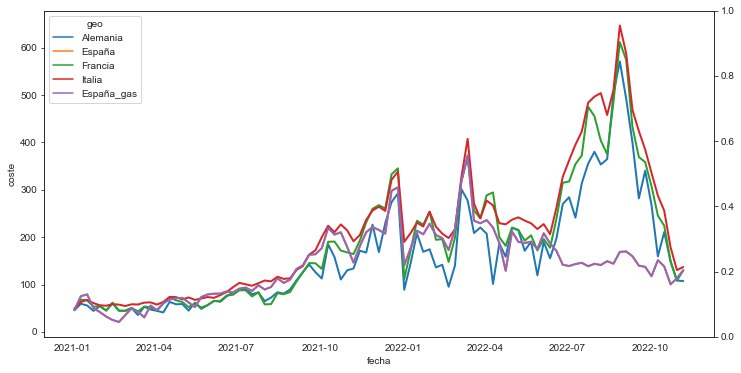

In [127]:
titulo = f'Demanda prevista vs Demanda programada vs Demanda real'
fuente = 'https://www.esios.ree.es'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['violet','green','orange']

sns.lineplot(
     data=total_precio,
     x='fecha', 
     y='coste',
     ci=None,
     estimator=sum,
     hue='geo',
     ax=ax,lw=2
     )

ax1 = ax.twinx()


'''ax.legend(loc=7,fontsize=18)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=9)
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW
ax.set_xticks(datos['fecha'].unique()[::72]) #6 horas de espaciado en eje X son 6*12 periodos de 5 min
ax.set_xticklabels([pd.to_datetime(i).strftime('%H:%M\n%d-%b') for i in datos['fecha'].unique()[::72]])
sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')'''

# Prueba de la libreria, para subir a GCP: diario

In [21]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [22]:
mayorista = esios_mayorista_diario(apikey_walyt,apisecretkey_walyt,AccessToken_walyt,
              AccessTokenSecret_walyt,token_esios,path_proyecto)

In [23]:
inicio = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')
inicio_titulo = (date.today()-timedelta(days=1)).strftime('%-d-%b')

In [24]:
historico = mayorista.load_historico(desde=inicio,hasta=inicio,filtro_geo='')

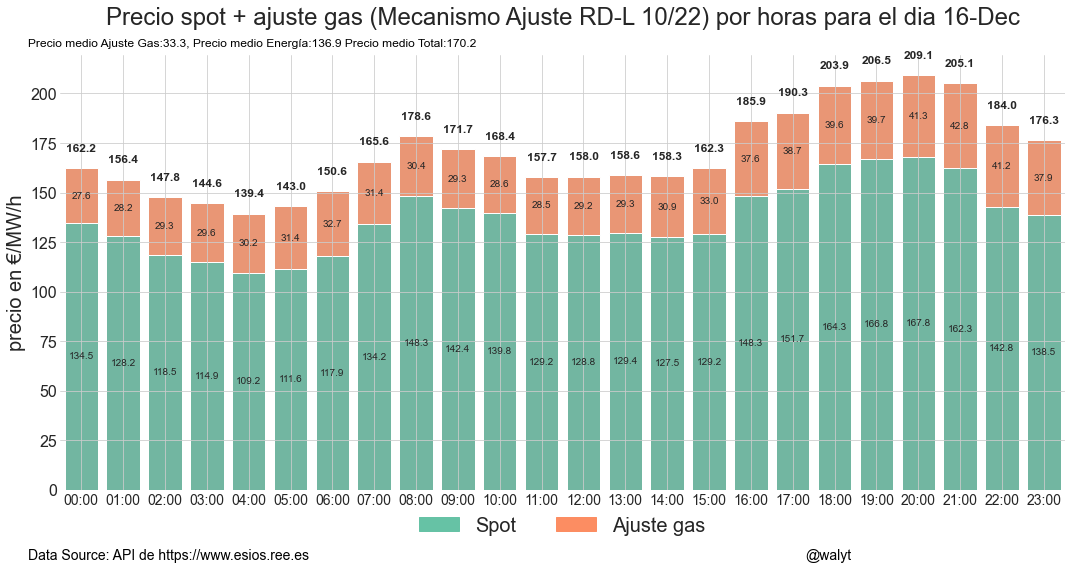

In [25]:
grafico,media_gas,media_spot, media_total = mayorista.grafico_mayorista_gas_diario()

In [26]:
texto = f"Mercado Ibérico de electricidad: Precio (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) de ayer {mayorista.fecha_titulo}"
texto = texto + '\n' + f'Precio medio Ajuste Gas:{media_gas:,.1f} €/MWh'
texto = texto + '\n' + f'Precio medio Energía:{media_spot:,.1f} €/MWh'
texto = texto + '\n' + f'Precio medio Total:{media_total:,.1f} €/MWh'
texto = texto + '\n' + '#esios #electricidad #mercadoibérico'



In [27]:
print (texto)

Mercado Ibérico de electricidad: Precio (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) de ayer 16-Dec
Precio medio Ajuste Gas:33.3 €/MWh
Precio medio Energía:136.9 €/MWh
Precio medio Total:170.2 €/MWh
#esios #electricidad #mercadoibérico


In [27]:
mayorista.enviar_tweet(grafico,texto)

Status(ID=1551236284152250368, ScreenName=walyt, Created=Sun Jul 24 16:02:05 +0000 2022, Text='Mercado Ibérico de electricidad: Precio (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) de ayer 23-Jul\nPreci… https://t.co/pxD8rkMdht')

# Prueba de la libreria, para subir a GCP: historico

In [60]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [61]:
mayorista = esios_mayorista(apikey_walyt,apisecretkey_walyt,AccessToken_walyt,
              AccessTokenSecret_walyt,token_esios,path_proyecto)

In [62]:
inicio = '2021-01-01'
ayer = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')

In [63]:
historico = mayorista.load_historico(desde=inicio,hasta=ayer,filtro_geo='')

In [13]:
historico.to_csv(path_proyecto+'data'+'/historico_mayorista.csv',index=False)

In [14]:
historico

,fecha,hora,coste,indicador
573,2021-07-01,0,0.000000,ajuste gas
574,2021-07-02,0,0.000000,ajuste gas
575,2021-07-03,0,0.000000,ajuste gas
576,2021-07-04,0,0.000000,ajuste gas
577,2021-07-05,0,0.000000,ajuste gas
...,...,...,...,...
568,2022-07-23,0,160.512500,Spot
569,2022-07-24,0,142.190833,Spot
570,2022-07-25,0,167.345000,Spot
571,2022-07-26,0,156.244167,Spot


In [22]:
mayorista.historico = pd.read_csv(path_proyecto+'data'+'/historico_mayorista.csv')
mayorista.fecha_titulo = '24-Julio'
mayorista.historico['fecha'] = pd.to_datetime(mayorista.historico['fecha'] ,utc=False)

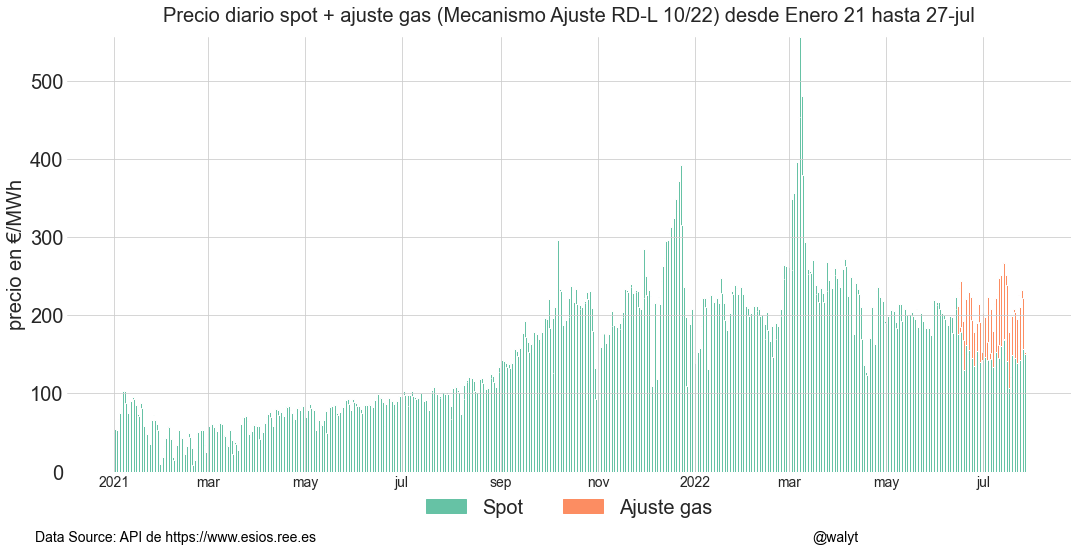

In [64]:
grafico = mayorista.grafico_mayorista_gas_diario()

In [24]:
texto = f"Mercado Ibérico de electricidad: Precio medio diario (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde Enero-21 hasta {mayorista.fecha_titulo}"
texto = texto + '\n' + '#esios #electricidad #mercadoibérico #spot #ajustegas'

In [25]:
mayorista.enviar_tweet(grafico,texto)

Status(ID=1552345247673454592, ScreenName=walyt, Created=Wed Jul 27 17:28:42 +0000 2022, Text='Mercado Ibérico de electricidad: Precio medio diario (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde E… https://t.co/72t8GFep2k')

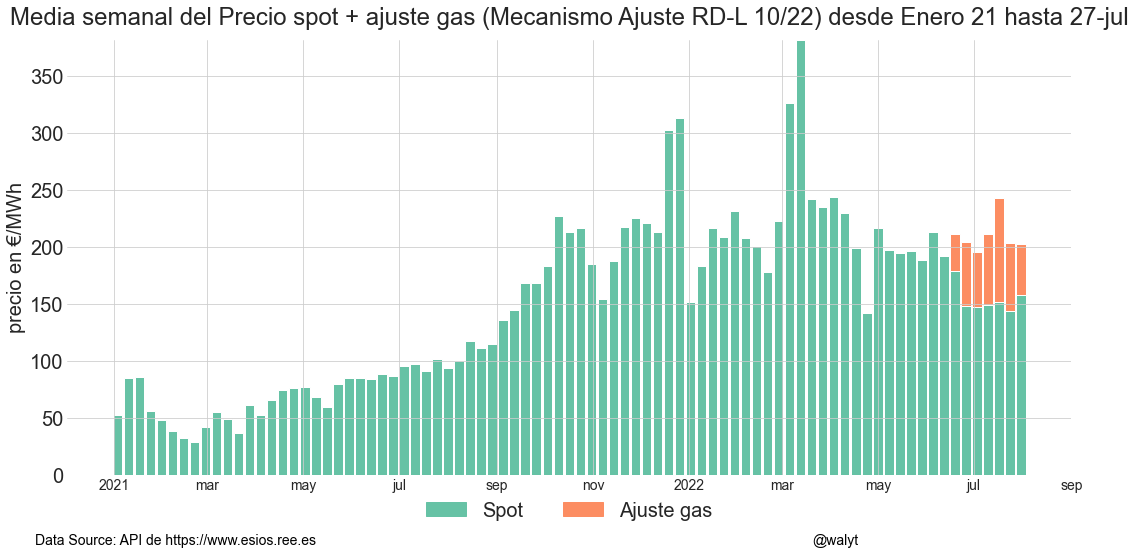

In [65]:
grafico = mayorista.grafico_mayorista_gas_semanal()

In [27]:
texto = f"Mercado Ibérico de electricidad: Precio medio semanal (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde Enero-21 hasta {mayorista.fecha_titulo}"
texto = texto + '\n' + '#esios #electricidad #mercadoibérico #spot #ajustegas'

In [28]:
mayorista.enviar_tweet(grafico,texto)

Status(ID=1552345267604701186, ScreenName=walyt, Created=Wed Jul 27 17:28:47 +0000 2022, Text='Mercado Ibérico de electricidad: Precio medio semanal (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde… https://t.co/jZFUYikwsZ')

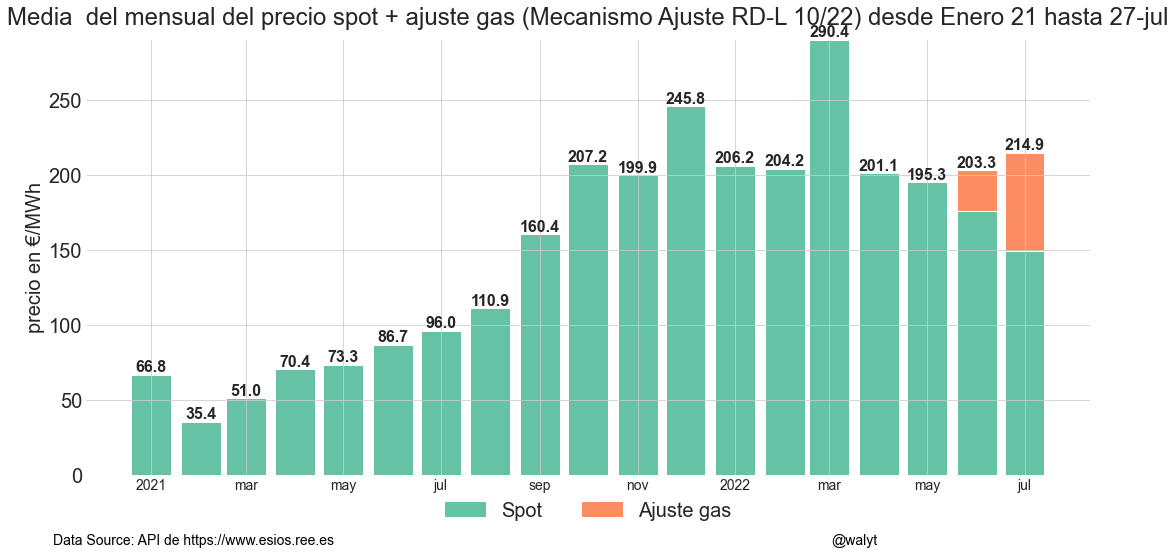

In [66]:
grafico = mayorista.grafico_mayorista_gas_mensual()

In [30]:
texto = f"Mercado Ibérico de electricidad: Precio medio mensual (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde Enero-21 hasta {mayorista.fecha_titulo}"
texto = texto + '\n' + '#esios #electricidad #mercadoibérico #spot #ajustegas'

In [31]:
mayorista.enviar_tweet(grafico,texto)

Status(ID=1552345288530137089, ScreenName=walyt, Created=Wed Jul 27 17:28:52 +0000 2022, Text='Mercado Ibérico de electricidad: Precio medio mensual (en €/MWh) por horas de Spot y Ajuste Gas (RD-L 10/22) desde… https://t.co/aW5gQMqqX3')

# Grafica países

In [9]:
import locale

In [10]:
locale.setlocale(locale.LC_ALL,'')

'es_ES.UTF-8'

In [4]:
path_proyecto = '/Users/mharias/documents/proyectos/consumo_luz/'

In [5]:
mayorista = esios_paises(apikey_walyt,apisecretkey_walyt,AccessToken_walyt,
              AccessTokenSecret_walyt,token_esios,path_proyecto)

In [6]:
inicio = '2021-01-01'
ayer = (date.today()-timedelta(days=1)).strftime('%Y-%m-%d')

In [7]:
historico = mayorista.load_historico(desde=inicio,hasta=ayer,filtro_geo='')

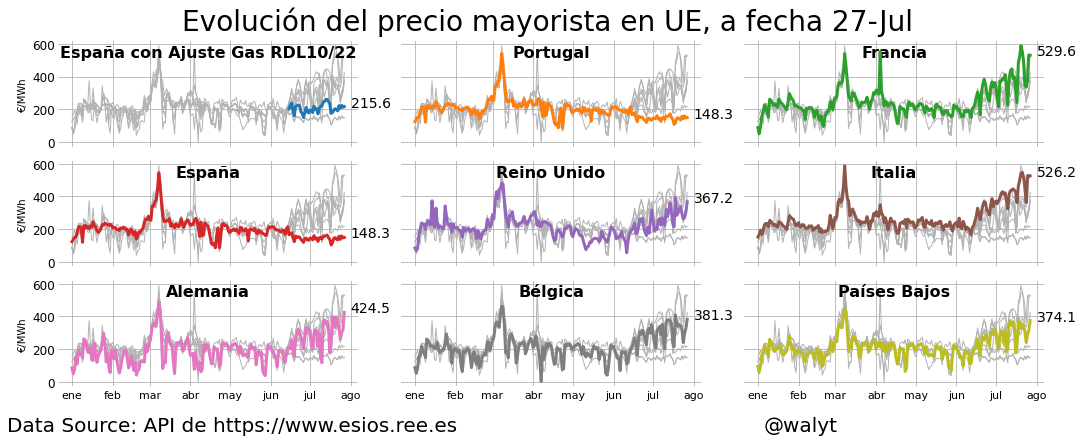

In [11]:
grafico = mayorista.grafico_mayorista_paises()

In [12]:
texto = f"Evolución del precio spot de electricidad en países de Europa, Precio medio mensual (en €/MWh). Desde Ene-22 hasta {mayorista.fecha_titulo}"
texto = texto + '\n' + '#esios #electricidad #mercadoibérico #mercado europeo #excepcioniberica #spot #ajustegas'

In [10]:
print (texto)

Evolución del precio spot de electricidad en países de Europa, Precio medio mensual (en €/MWh). Desde Ene-22 hasta 26-jul
#esios #electricidad #mercadoibérico #mercado europeo #excepcioniberica #spot #ajustegas


In [13]:
mayorista.enviar_tweet(grafico,texto)

Status(ID=1552734713055481856, ScreenName=walyt, Created=Thu Jul 28 19:16:18 +0000 2022, Text='Evolución del precio spot de electricidad en países de Europa, Precio medio mensual (en €/MWh). Desde Ene-22 hasta… https://t.co/biJySNia5Y')